## We now attempt to find out if the way a SEC filing is done has an effect on the returns

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import scipy.stats as stats

# Remove warnings to keep outputs clean
import warnings
warnings.filterwarnings("ignore")

PROCESSED_DATA_FOLDER = "../../data_untracked/processed"
ABNORMAL_CSV = "merged_txns_SNORKEL.csv"

## Load required datasets
1. `df_result_with_anomaly_scores_sig.csv`: Transactions with their Cumulative Abnormal Returns (CAR)
2. `FOOTNOTES.csv`: Each transactions with their individual filing comments

In [2]:
abnormal_transactions = pd.read_csv(f'{PROCESSED_DATA_FOLDER}/{ABNORMAL_CSV}')[["ACCESSION_NUMBER", "TRANS_CODE", "TRANS_ACQUIRED_DISP_CD", "snorkel_prob", "snorkel_pred"]]
abnormal_transactions = abnormal_transactions.rename(columns={"snorkel_prob" : "probability",
                                                               "snorkel_pred" : "prediction"})
print("Loading data")

Loading data


___
## Feature extraction and engineering
___

In [3]:
abnormal_transactions.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction
0,0001181431-09-023155,S,D,1.000000,1
1,0001181431-12-005367,S,D,1.000000,1
2,0001181431-12-047732,S,D,0.090053,0
3,0001181431-12-047732,S,D,0.090053,0
4,0001181431-12-049839,S,D,0.219855,0


In [4]:
abnormal_transactions["TRANS_ACQUIRED_DISP_CD"].count()

3171001

In [5]:
abnormal_transactions = abnormal_transactions.drop_duplicates(subset=["ACCESSION_NUMBER", "TRANS_ACQUIRED_DISP_CD", "TRANS_CODE", "probability"])
abnormal_transactions.shape

(1299397, 5)

In [57]:
df_features = abnormal_transactions.copy()

## Create a binary variable to extract Transcode = J
df_features["j_bin"] = np.where(df_features["TRANS_CODE"].str.upper() == "J", 1, 0)

##############################
# Sell
##############################

## Create a binary variable to extract Transcode = J and Trans Acquired = D which means J code and sell
df_features["js_bin"] = np.where((df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "D") & (df_features["TRANS_CODE"].str.upper() == "J"), 1, 0)

## Create a binary variable to extract Transcode Not J or S but Trans Acquired = D which is sell but non S or J or G coded
df_features["os_bin"] = np.where((~df_features["TRANS_CODE"].str.upper().isin(["S", "J", "G"])) & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "D"), 1, 0)

## Create a binary variable to extract Transcode = S which is sell and Acquired disp cd = D (Regular Sell)
df_features["s_bin"] = np.where((df_features["TRANS_CODE"].str.upper() == "S") & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "D" ), 1, 0)

##############################
# Buy
##############################

## Create a binary variable to extract Transcode = P which is Buy and Acquired disp cd = A (Regular Sell)
df_features["b_bin"] = np.where((df_features["TRANS_CODE"].str.upper() == "P") & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "A"), 1, 0)

## Create a binary variable to extract Transcode = J and Trans Acquired = A which means J code and buy
df_features["jb_bin"] = np.where((df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "A") & (df_features["TRANS_CODE"].str.upper() == "J"), 1, 0)

## Create a binary variable to extract Transcode Not J or P but Trans Acquired = A which is buy but non P or J or G coded
df_features["ob_bin"] = np.where((~df_features["TRANS_CODE"].str.upper().isin(["P", "J", "G"])) & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "A"), 1, 0)

##############################
# GIFTS
##############################

## Create a binary variable to extract if Transcode = G which is a gift
df_features["g_bin"] = np.where((df_features["TRANS_CODE"].str.upper() == "G"), 1, 0)

## Create a binary variable to extract if Transcode = G which is a gift and buy
df_features["gb_bin"] = np.where((df_features["TRANS_CODE"].str.upper() == "G") & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "A"), 1, 0)

## Create a binary variable to extract if Transcode = G which is a gift and sell
df_features["gs_bin"] = np.where((df_features["TRANS_CODE"].str.upper() == "G") & (df_features["TRANS_ACQUIRED_DISP_CD"].str.upper() == "D"), 1, 0)


In [58]:
print(f'rows with binary j: {sum(df_features["j_bin"])}')
print(f'rows with binary j and sell: {sum(df_features["js_bin"])} \t rows with regular sell: {sum(df_features["s_bin"])} \t rows with non-regular sell: {sum(df_features["os_bin"])}')
print(f'rows with binary j and buy: {sum(df_features["jb_bin"])} \t rows with regular buy: {sum(df_features["b_bin"])} \t\t rows with non-regular buy: {sum(df_features["ob_bin"])}')


rows with binary j: 141229
rows with binary j and sell: 35699 	 rows with regular sell: 730187 	 rows with non-regular sell: 5381
rows with binary j and buy: 105530 	 rows with regular buy: 303443 		 rows with non-regular buy: 11188


In [59]:
total_sell = sum(df_features["js_bin"]) + sum(df_features["s_bin"]) + sum(df_features["os_bin"])
total_buy = sum(df_features["jb_bin"]) + sum(df_features["b_bin"]) + sum(df_features["ob_bin"])
print(f"All cases accounted for: {len(df_features) == total_sell + total_buy}")

All cases accounted for: False


___
## Comparison
___

In [60]:
metrics = [
    "probability", "prediction"
]

In [61]:
##################################
# Define functions
##################################

def compare_complement(df, col, metrics):
    split_1 = df[df[col] == 1]
    split_2 = df[df[col] != 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col} is separated\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col} = {np.mean(A)}, mean {col} complement = {np.mean(B)}\n")
        
    print(f"{col}: n = {len(A)}, {col} complement: n = {len(B)}")

def compare_columns(df, col1, col2, metrics):
    split_1 = df[df[col1] == 1]
    split_2 = df[df[col2] == 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col1} compared to {col2}\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col1} = {np.mean(A)}, mean {col2} = {np.mean(B)}\n")
    print(f"{col1}: n = {len(A)}, {col2} : n = {len(B)}")
    

In [62]:
## The inclusion of g code not significant in the probability continous labels
compare_complement(df_features, "g_bin", metrics)

probability: is more positive when g_bin is separated
t-statistic = 77.78913465363631, p-value = 0.0
mean g_bin = 0.7566984819710943, mean g_bin complement = 0.6758130280910594

prediction: is more positive when g_bin is separated
t-statistic = 88.20304332739661, p-value = 0.0
mean g_bin = 0.6166214376348766, mean g_bin complement = 0.4800055059978446

g_bin: n = 107969, g_bin complement: n = 1191428


In [63]:
## The inclusion of g code not significant in the probability continous labels
compare_complement(df_features, "gb_bin", metrics)

probability: is more positive when gb_bin is separated
t-statistic = 20.0379282096194, p-value = 1.2977494445816793e-88
mean gb_bin = 0.7263549929591401, mean gb_bin complement = 0.6817131013525093

prediction: is more positive when gb_bin is separated
t-statistic = 24.273193911423565, p-value = 1.1915081391891543e-128
mean gb_bin = 0.5684329482672024, mean gb_bin complement = 0.48991340684669993

gb_bin: n = 23892, gb_bin complement: n = 1275505


In [64]:
compare_complement(df_features, "gs_bin", metrics)

probability: is more positive when gs_bin is separated
t-statistic = 76.97505608239422, p-value = 0.0
mean gs_bin = 0.7653211331060492, mean gs_bin complement = 0.6768066335814883

prediction: is more positive when gs_bin is separated
t-statistic = 86.10905528115474, p-value = 0.0
mean gs_bin = 0.6303150683302211, mean gs_bin complement = 0.4817439028404042

gs_bin: n = 84077, gs_bin complement: n = 1215320


In [65]:
compare_columns(df_features, "gb_bin", "gs_bin", metrics)

probability: is more negative when gb_bin compared to gs_bin
t-statistic = -15.770492438064897, p-value = 7.571272209874066e-56
mean gb_bin = 0.7263549929591401, mean gs_bin = 0.7653211331060492

prediction: is more negative when gb_bin compared to gs_bin
t-statistic = -17.136872253998508, p-value = 1.3959165517454705e-65
mean gb_bin = 0.5684329482672024, mean gs_bin = 0.6303150683302211

gb_bin: n = 23892, gs_bin : n = 84077


In [66]:
compare_columns(df_features, "gb_bin", "g_bin", metrics)

probability: is more negative when gb_bin compared to g_bin
t-statistic = -12.53250624763656, p-value = 5.946007493724206e-36
mean gb_bin = 0.7263549929591401, mean g_bin = 0.7566984819710943

prediction: is more negative when gb_bin compared to g_bin
t-statistic = -13.652880067910067, p-value = 2.4948801509597524e-42
mean gb_bin = 0.5684329482672024, mean g_bin = 0.6166214376348766

gb_bin: n = 23892, g_bin : n = 107969


In [67]:
## The inclusion of j code is significant to the anomaly level at 0.05 level however, we can split it further in sells and buys
compare_complement(df_features, "j_bin", metrics)

probability: is more negative when j_bin is separated
t-statistic = -66.76692805712239, p-value = 0.0
mean j_bin = 0.6255915200433525, mean j_bin complement = 0.6894775870583619

prediction: is more negative when j_bin is separated
t-statistic = -71.73205574060563, p-value = 0.0
mean j_bin = 0.4027855468777659, mean j_bin complement = 0.5021577180512672

j_bin: n = 141229, j_bin complement: n = 1158168


## Compare sells

In [68]:
##################################
# Compare Regular Sell to other-coded Sell
##################################

compare_columns(df_features, "s_bin", "os_bin", metrics)

probability: is more negative when s_bin compared to os_bin
t-statistic = -18.451489105094957, p-value = 8.43566796756432e-74
mean s_bin = 0.6801463507852918, mean os_bin = 0.7585777918212866

prediction: is more negative when s_bin compared to os_bin
t-statistic = -17.730654575535688, p-value = 1.948373281586839e-68
mean s_bin = 0.49823127500215697, mean os_bin = 0.6162423341386359

s_bin: n = 730187, os_bin : n = 5381


In [69]:
##################################
# Compare Regular Sell to J-coded Sell
##################################

compare_columns(df_features, "s_bin", "js_bin", metrics)

probability: is more negative when s_bin compared to js_bin
t-statistic = -16.801271319974223, p-value = 3.9461499465042547e-63
mean s_bin = 0.6801463507852918, mean js_bin = 0.7090887994044911

prediction: is more negative when s_bin compared to js_bin
t-statistic = -16.0799713997554, p-value = 5.401980703664233e-58
mean s_bin = 0.49823127500215697, mean js_bin = 0.5416678338328804

s_bin: n = 730187, js_bin : n = 35699


### J-Coded sells does not have significance compared to Other-Coded sells

In [70]:
##################################
# Compare J-coded Sell to Others-sell 
##################################

compare_columns(df_features, "js_bin", "os_bin", metrics)

probability: is more negative when js_bin compared to os_bin
t-statistic = -10.871353795091991, p-value = 2.575386238552257e-27
mean js_bin = 0.7090887994044911, mean os_bin = 0.7585777918212866

prediction: is more negative when js_bin compared to os_bin
t-statistic = -10.451603027713812, p-value = 2.1888570894261834e-25
mean js_bin = 0.5416678338328804, mean os_bin = 0.6162423341386359

js_bin: n = 35699, os_bin : n = 5381


## Compare buys

In [71]:
##################################
# Compare Regular Buy to J-coded Buy
##################################

compare_columns(df_features, "b_bin", "jb_bin", metrics)

probability: is more positive when b_bin compared to jb_bin
t-statistic = 75.50749218219808, p-value = 0.0
mean b_bin = 0.6885914578634618, mean jb_bin = 0.5973458138374086

prediction: is more positive when b_bin compared to jb_bin
t-statistic = 66.27450605189225, p-value = 0.0
mean b_bin = 0.4704606796004521, mean jb_bin = 0.3558040367667962

b_bin: n = 303443, jb_bin : n = 105530


In [72]:
##################################
# Compare Regular Buy to other-coded Buy
##################################

compare_columns(df_features, "b_bin", "ob_bin", metrics)

probability: is more positive when b_bin compared to ob_bin
t-statistic = 13.695216534028418, p-value = 2.2791025500725693e-42
mean b_bin = 0.6885914578634618, mean ob_bin = 0.6405712693206541

prediction: is more positive when b_bin compared to ob_bin
t-statistic = 2.468888132383408, p-value = 0.01356714915872825
mean b_bin = 0.4704606796004521, mean ob_bin = 0.4586163746871648

b_bin: n = 303443, ob_bin : n = 11188


In [73]:
##################################
# Compare J-coded Buy to other-coded Buy
##################################

compare_columns(df_features, "jb_bin", "ob_bin", metrics)

probability: is more negative when jb_bin compared to ob_bin
t-statistic = -11.958572555508736, p-value = 8.608320449218971e-33
mean jb_bin = 0.5973458138374086, mean ob_bin = 0.6405712693206541

prediction: is more negative when jb_bin compared to ob_bin
t-statistic = -20.828152802037973, p-value = 7.468013622593535e-95
mean jb_bin = 0.3558040367667962, mean ob_bin = 0.4586163746871648

jb_bin: n = 105530, ob_bin : n = 11188


### Sell
Propose to split sell into 3 Features: Regular sell, J-coded sells and Other sells

### Buy
Propose to split sell into 3 Features: Regular Buys, J-coded buy and other buys

However, we will remove one of the column to remove collinearity. Then we will check the significance of the model

___
## Checking significance in model
___

In [74]:
df_features.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,j_bin,js_bin,os_bin,s_bin,b_bin,jb_bin,ob_bin,g_bin,gb_bin,gs_bin
0,0001181431-09-023155,S,D,1.000000,1,0,0,0,1,0,0,0,0,0,0
1,0001181431-12-005367,S,D,1.000000,1,0,0,0,1,0,0,0,0,0,0
2,0001181431-12-047732,S,D,0.090053,0,0,0,0,1,0,0,0,0,0,0
4,0001181431-12-049839,S,D,0.219855,0,0,0,0,1,0,0,0,0,0,0
5,0001181431-12-049839,S,D,0.090053,0,0,0,0,1,0,0,0,0,0,0


In [75]:
def find_significance(data, columns, label):
    data = data.dropna(subset=[label])
    X = data[columns]
    y = data[label]
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
    
    X_with_const = sm.add_constant(train_x)
    model = sm.Logit(train_y, X_with_const).fit()
    # results = model.fit()

    print(model.summary())

In [81]:
variables = ['js_bin', 's_bin','b_bin', 'jb_bin', 'ob_bin', 'gb_bin', 'g_bin'] # Removed "os_bin" and "gs_bin" to ensure that collinearity is removed
label = ["probability"]
find_significance(df_features, variables, label[0])

Optimization terminated successfully.
         Current function value: 0.592192
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:              1039517
Model:                          Logit   Df Residuals:                  1039509
Method:                           MLE   Df Model:                            7
Date:                Fri, 11 Apr 2025   Pseudo R-squ.:                -0.03717
Time:                        14:59:06   Log-Likelihood:            -6.1559e+05
converged:                       True   LL-Null:                   -5.9353e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1386      0.036     31.956      0.000       1.069       1.208
js_bin        -0.2539      0.

In [82]:
variables = ['js_bin', 's_bin','b_bin', 'jb_bin', 'ob_bin', 'gb_bin'] # Removed "g_bin" as it is not significant
label = ["probability"]
find_significance(df_features, variables, label[0])

Optimization terminated successfully.
         Current function value: 0.592191
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            probability   No. Observations:              1039517
Model:                          Logit   Df Residuals:                  1039510
Method:                           MLE   Df Model:                            6
Date:                Fri, 11 Apr 2025   Pseudo R-squ.:                -0.03717
Time:                        14:59:15   Log-Likelihood:            -6.1559e+05
converged:                       True   LL-Null:                   -5.9353e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1807      0.009    133.970      0.000       1.163       1.198
js_bin        -0.2960      0.

### The variables:

js_bin: Indicates 1 if it is a J-coded sell 0 otherwise

s_bin: Indicates 1 if it is a S-coded sell and trans acquired D 0 otherwise

b_bin: Indicates 1 if it is a P-coded buy and trans acquired A 0 otherwise

jb_bin: Indicates 1 if it is a J-coded buy 0 otherwise

ob_bin: Indicates 1 if it is a non-J non-S non-G coded buy 0 otherwise

gb_bin: Indicates 1 if the Trans code is g and trans acquired A 0 otherwise


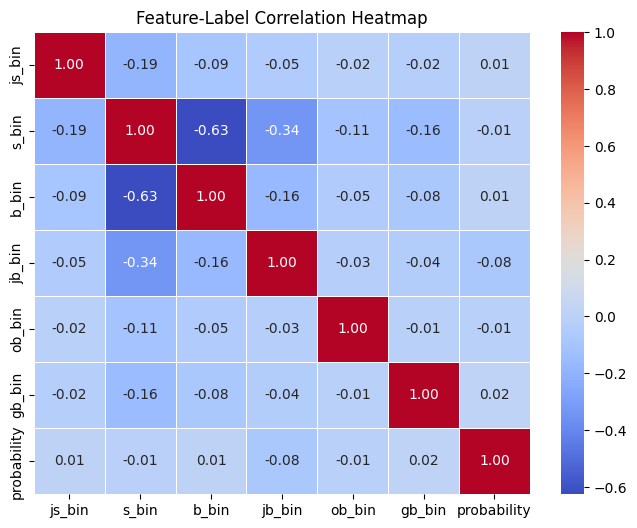

In [78]:
corr = df_features[variables + label].corr(method="pearson")
# corr = df_features.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()